In [1]:
from typing import Tuple, Optional
from data.hysteresis import hysteresis_ode
from data.utils import _load_wrapper
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from scipy.integrate import solve_ivp

In [2]:
def simulate_steady_state(
    lam_values, 
    x0, 
    t_span:Tuple[float, float],
    t_eval: Optional[np.ndarray] = None,
    show_progress: bool = True):
    """
    lam_values: control params 
    x0: initial state observation
    t_span: start and stop time of ode solution 
    t_eval: Points at which to save results. Default is end of t_span.
    show_progress: Show progress bar (tqdm)
    
    """
    wrapper = _load_wrapper(show_progress)

    x_curr = np.array([x0])
    
    if t_eval is None:
        t_eval = np.array([t_span[-1]])
    
    for idx, lam in enumerate(wrapper(lam_values)):
        sol = solve_ivp(
            hysteresis_ode, 
            t_span=t_span, 
            y0=x_curr, 
            args=(lam,), 
            t_eval=t_eval
        )

        x_curr = sol.y[:, -1]  # final value

        lam_i = np.array([lam]*len(t_eval))
        
        if idx == 0:
            x_vals = sol.y
            lam_vals = lam_i
            t_vals = t_eval
        
        else:
            x_vals = np.hstack((x_vals, sol.y))
            lam_vals = np.hstack((lam_vals,lam_i))
            t_vals = np.hstack((t_vals,t_eval + t_eval[-1]*idx))

        
    return x_vals, lam_vals, t_vals


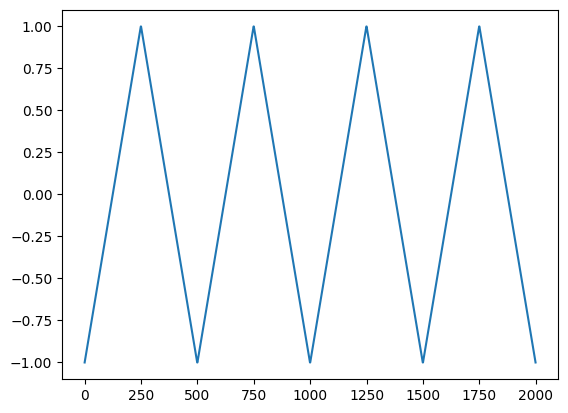

In [13]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam = np.hstack((lam_increase,lam_decrease))
repeat = 2
for _ in range(repeat):
    lam = np.hstack((lam, lam))
plt.plot(lam)

In [14]:
t_eval = np.linspace(0,50,101)
# t_eval = None
x0s = np.linspace(-1.5, -0.8, 11)
Xs = []
for x0 in tqdm(x0s):
    Xi, lams, T = simulate_steady_state(lam, x0, t_span=[0,50], t_eval=t_eval, show_progress=False)
    Xs.append(Xi)

  0%|          | 0/11 [00:00<?, ?it/s]

In [15]:
T.shape

(202000,)

  0%|          | 0/11 [00:00<?, ?it/s]

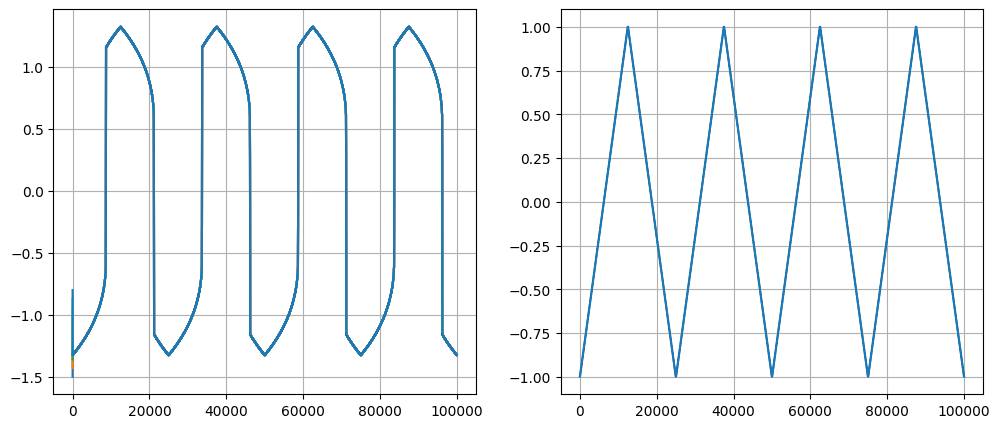

In [23]:
cutoff = -1
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
for idx, x0 in enumerate(tqdm(x0s)):
    ax1.plot(T[:cutoff], Xs[idx][0, :cutoff], label=rf"$x_0$ = {x0:.3f}")
# ax1.legend(prop={'family': 'serif'})
ax1.grid(True)
# ax1.set_yscale('log')
ax2.plot(T[:cutoff], lams[:cutoff])
ax2.grid(True)
# plt.tight_layout()

plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

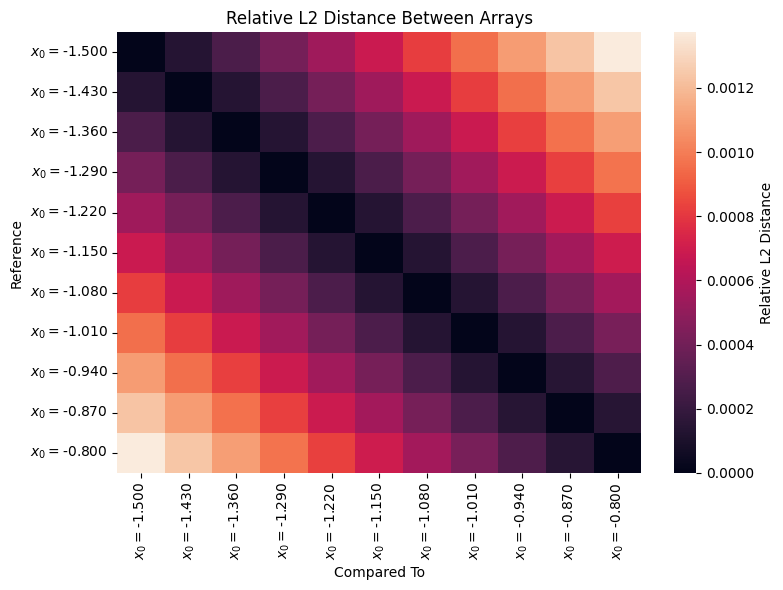

In [19]:
l2_rel_err = lambda x,y: np.linalg.norm(x-y) / np.linalg.norm(x)
names = [rf"$x_0=${x0:.3f}" for x0 in x0s]
series = pd.Series(Xs, index =names)
dist_df = pd.DataFrame(index=names, columns=names, dtype=float)
for i in tqdm(names):
    for j in names:
        dist_df.loc[i,j] = l2_rel_err(series[i], series[j])

fig, ax = plt.subplots(1,1, figsize = (8,6))
sns.heatmap(dist_df, annot=False, fmt=".4f", cmap="rocket", cbar_kws={'label': 'Relative L2 Distance'})
plt.title("Relative L2 Distance Between Arrays")
plt.xlabel("Compared To")
plt.ylabel("Reference")
plt.tight_layout()
plt.show()


## Peturbations